In [7]:
from copy import deepcopy
from pathlib import Path
import os
import pickle
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns
import tifffile
import yaml

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [16]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.data.xenium as xenium
import mushroom.data.cosmx as cosmx
import mushroom.data.multiplex as multiplex
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.visualization.tiling_utils as tiling_utils

In [5]:
project_dir = Path('/data/estorrs/mushroom/data/projects/submission_v1/')

In [6]:
os.listdir(project_dir)

['HT553P1-H2',
 'S18-25943-A7',
 'S18-5591-C8',
 'HT413C1-K2',
 'HT339B2-H1',
 'HT413C1-Th1k4A1',
 'kidney',
 'HT565B1-H2',
 'WD-76845',
 'analysis',
 'C3L-00970',
 'HT704B1',
 'C3L-00982',
 'HT225C1',
 'S18-9906',
 'HT268B1',
 'C3L-02551',
 'C3L-01287',
 'HT206B1',
 'HT448C1-Th1K1Fp1',
 'HT397B1']

In [521]:
multiplex_view_settings = [
    {
        'channel': 'E-cadherin',
        'color': 'red',
        'min_value': 15,
        'max_value': 100,
        'gamma': 1.
    },
    {
        'channel': 'HLA-DR',
        'color': 'magenta',
        'min_value': 15,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'Keratin 5',
        'color': 'white',
        'min_value': 15,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'CD3e',
        'color': 'green',
        'min_value': 20,
        'max_value': 75,
        'gamma': 1.
    },
    {
        'channel': 'CD68',
        'color': 'cyan',
        'min_value': 15,
        'max_value': 255,
        'gamma': 1.
    },
]

def get_multiplex_pseudo(fp, view_settings):
    channels = [x['channel'] for x in view_settings]
    colors = [x['color'] for x in view_settings]
    min_values = [x['min_value'] for x in view_settings]
    max_values = [x['max_value'] for x in view_settings]
    gammas = [x['gamma'] for x in view_settings]
    
    channel_to_img = multiplex.extract_ome_tiff(fp, as_dict=True)
    data = np.stack([channel_to_img[x] for x in channels])
    
    rgb = multiplex.to_pseudocolor(
        data,
        colors=colors,
        min_values=min_values,
        max_values=max_values,
        gammas=gammas
    )
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

xenium_view_settings = [
    {
        'channel': 'EPCAM',
        'color': 'red',
        'min_value': 0,
        'max_value': 20,
        'gamma': 1.
    },
    {
        'channel': 'HLA-DQB2',
        'color': 'magenta',
        'min_value': 0,
        'max_value': 50,
        'gamma': 1.
    },
    {
        'channel': 'KRT5',
        'color': 'white',
        'min_value': 0,
        'max_value': 20,
        'gamma': 1.
    },
    {
        'channel': 'CD3E',
        'color': 'green',
        'min_value': 0,
        'max_value': 50,
        'gamma': 1.
    },
    {
        'channel': 'CD68',
        'color': 'cyan',
        'min_value': 0,
        'max_value': 50,
        'gamma': 1.
    },
]

def tile_xenium(adata, target_size=None, tile_size=20):
    if target_size is None:
        target_size = xenium.get_fullres_size(adata)
    
    adata.obs['grid_name'] = [f'{x // tile_size}_{y // tile_size}' for x, y in adata.obsm['spatial']]
    df = pd.DataFrame(data=adata.X, columns=adata.var.index.to_list(), index=adata.obs.index.to_list())
    df['grid_name'] = adata.obs['grid_name'].to_list()
    df = df.groupby('grid_name').sum()
    
    img = np.zeros((target_size[0] // tile_size + 1, target_size[1] // tile_size + 1, df.shape[1]))
    for name, row in df.iterrows():
        x, y = [int(x) for x in name.split('_')]
        img[y, x] = row.values
    return img
    

def get_xenium_pseudo(fp, view_settings, tile_size=20, target_size=None):
    channels = [x['channel'] for x in view_settings]
    colors = [x['color'] for x in view_settings]
    min_values = [x['min_value'] for x in view_settings]
    max_values = [x['max_value'] for x in view_settings]
    gammas = [x['gamma'] for x in view_settings]
    
    adata = xenium.adata_from_xenium(fp)
    if target_size is None:
        target_size = xenium.get_fullres_size(adata)
    
    img = tile_xenium(adata, tile_size=tile_size)
    
    data = img[..., [adata.var.index.to_list().index(x) for x in channels]]
    data -= data.min((0, 1))
    data /= data.max((0, 1))
    data *= 255.
    data = data.astype(np.uint8)
    data = rearrange(data, 'h w c -> c h w')
    
    rgb = multiplex.to_pseudocolor(
        data,
        colors=colors,
        min_values=min_values,
        max_values=max_values,
        gammas=gammas
    )
    rgb = utils.rescale(rgb, size=target_size, dim_order='h w c', target_dtype=rgb.dtype)
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
#     plt.imshow(rgb[4000:4500, 4000:4500])
#     plt.show()
    
    return rgb

In [12]:
cases = [
    'HT397B1',
    'HT206B1',
    'HT704B1'
]
case_to_config = {case:yaml.safe_load(open(project_dir / case / 'mushroom_50res' / 'config.yaml'))
                  for case in cases}

In [13]:
case_to_threshold = {
    'HT397B1': 45.,
    'HT206B1': 45.,
    'HT704B1': 45.
}


In [14]:
case_to_config['HT704B1']['sections']

[{'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s0_HT704B1-U1_xenium.h5ad'}],
  'position': 0,
  'sid': 'HT704B1-U1'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s1_HT704B1-U11_multiplex.ome.tiff'}],
  'position': 50,
  'sid': 'HT704B1-U11'},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s2_HT704B1-U12_he.tif'}],
  'position': 55,
  'sid': 'HT704B1-U12'},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s4_HT704B1-U15_he.tif'}],
  'position': 70,
  'sid': 'HT704B1-U15'},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s5_HT704B1-U17_xenium.h5ad'}],
  'position': 80,
  'sid': 'HT704B1-U17'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '

In [523]:
fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s0_HT704B1-U1_xenium.h5ad'
adata = xenium.adata_from_xenium(fp)
adata

AnnData object with n_obs × n_vars = 224958 × 476
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ppm', 'spatial'
    obsm: 'spatial'

In [453]:
tiling_size = 20

In [454]:
target_size = [int(x) for x in np.asarray(xenium.get_fullres_size(adata)) / tiling_size]
target_size

[362, 453]

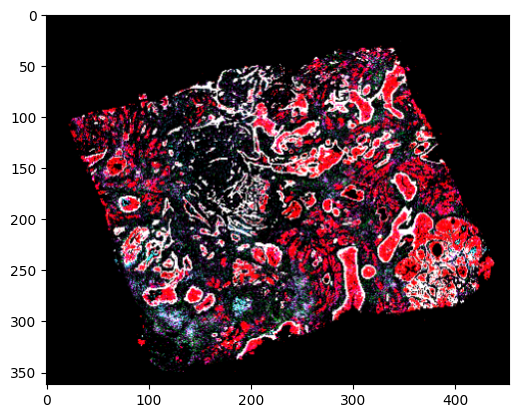

In [524]:
pseudo = get_xenium_pseudo(fp, xenium_view_settings, tile_size=tiling_size, target_size=target_size)
plt.imshow(pseudo)

In [631]:
[c for c in adata.var.index if 'PD' in c]

['ENTPD1', 'NPDC1', 'PDCD1', 'PDGFRA', 'PDGFRB', 'PDPN', 'SPDEF']

In [633]:
xenium_channels = [
    'EPCAM', 'KRT5', 'PTPRC', 'CD4', 'CD8A', 'MS4A1', 'CD68', 'CD163', 'ACTA2', 'PDPN', 'HLA-DQB2', 'LAG3', 'PDCD1', 'GZMB'
]
xenium_tiled = tiling_utils.get_tiled_sections(
    case_to_config['HT704B1'], dtype='xenium', channel_names=xenium_channels,
    tiling_size=tiling_size, target_size=target_size
)
xenium_tiled.shape

/data/estorrs/mushroom/mushroom/visualization/tiling_utils.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['grid_name'] = [f'{x // tile_size}_{y // tile_size}' for x, y in adata.obsm['spatial']]
/data/estorrs/mushroom/mushroom/visualization/tiling_utils.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['grid_name'] = [f'{x // tile_size}_{y // tile_size}' for x, y in adata.obsm['spatial']]
/data/estorrs/mushroom/mushroom/visualization/tiling_utils.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['grid_name'] = [f'{x // tile_size}_{y // tile_size}' for x, y in adata.obsm['spatial']]
/data/estorrs/mushroom/mushroom/visualization/tiling_utils.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['grid_name'] = [f'{x

(6, 14, 362, 453)

In [627]:
def to_masks(tiled, thresh, index=0):
    masks = []
    for img in tiled[:, index]:
        mask = img > thresh
        mask = binary_fill_holes(mask)
        masks.append(mask)
    masks = np.stack(masks)
    return masks

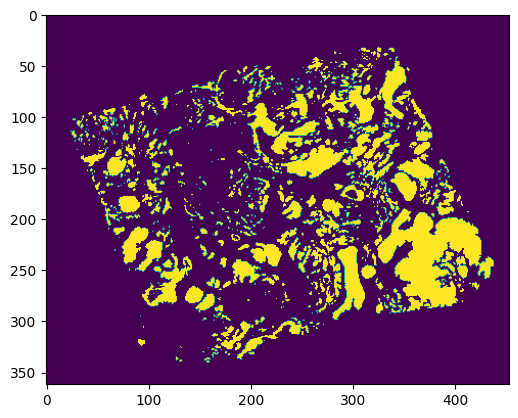

In [634]:
xenium_masks = to_masks(xenium_tiled, 20, index=0)
plt.imshow(xenium_masks[0])

In [625]:
multiplex_channels = multiplex.get_ome_tiff_channels(
    '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s1_HT704B1-U11_multiplex.ome.tiff'
)
multiplex_channels

['DAPI',
 'Granzyme B',
 'Keratin 5',
 'PLAT/tPA (D)',
 'CTLA4 (D)',
 'CD31',
 'CD4 (D)',
 'SLC39A6 (D)',
 'TCF-1',
 'BCA1',
 'CD68',
 'CD39',
 'FOXP3',
 'CD163',
 'PD-1',
 'MLPH',
 'CD8',
 'HER2 (D)',
 'GLUT1 (D)',
 'ckit-(D)',
 'Pan-Cytokeratin',
 'HIF1a',
 'Podoplanin (D)',
 'CD20',
 'HLA-DR',
 'CK14 (D)',
 'TFF1 (D)',
 'MGP (D)',
 'Ki67',
 'Vimentin',
 'CD3e',
 'E-cadherin',
 'SMA (D)',
 'cd11b',
 'PR (D)',
 'CD45 (D)',
 'GATA3',
 'COX6C (D)']

In [626]:
multiplex_tiled = tiling_utils.get_tiled_sections(
    case_to_config['HT704B1'], dtype='multiplex', channel_names=multiplex_channels,
    tiling_size=tiling_size, target_size=target_size
)
multiplex_tiled.shape

(9, 38, 362, 453)

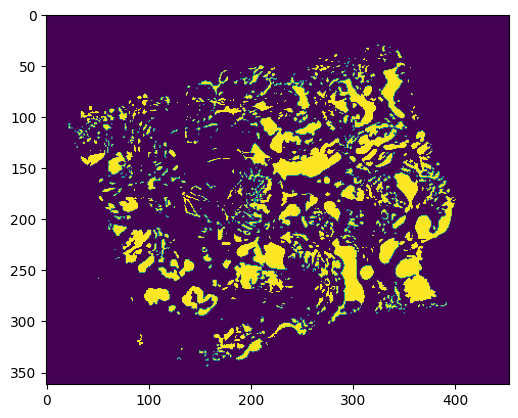

In [628]:
multiplex_masks = to_masks(multiplex_tiled, 20, index=multiplex_channels.index('E-cadherin'))
plt.imshow(multiplex_masks[0])

In [205]:
# cosmx_tiled = tiling_utils.get_tiled_sections(
#     case_to_config['HT704B1'], dtype='cosmx', channel_names=['EPCAM', 'KRT5'],
#     tiling_size=20, target_size=target_size
# )
# cosmx_tiled.shape

In [206]:
# img = cosmx_tiled[0, 0].copy()
# mask = img>40
# mask = binary_fill_holes(mask)
# plt.imshow(mask)

In [588]:
def to_stacked_rgb(config, dtype_to_masks, dtype_to_tiled, value_idx,
                   dtype_to_vmax=50., spacing_scaler=10, squish_scaler=2):
    target_size = next(iter(dtype_to_masks.values()))[0].shape[:2]
    dtypes = dtype_to_masks.keys()
    
    positions, sids, dts = zip(*[(entry['position'], entry['sid'], entry['data'][0]['dtype'])
                                    for entry in config['sections']
                                    if entry['data'][0]['dtype'] in dtypes])
    
    sid_to_data = {}
    for dtype in dtypes:
        intensities = dtype_to_tiled[dtype]
        masks = dtype_to_masks[dtype]
        vmax = dtype_to_vmax if not isinstance(dtype_to_vmax, dict) else dtype_to_vmax[dtype]
        ps, ids = zip(*[(p, sid) for sid, p, dt in zip(sids, positions, dts) if dt == dtype])
        for sid, mask, intensity, position in zip(ids, masks, intensities, ps):
            rgb, props = to_cmapped_rgb(mask, intensity, value_idx, vmax=vmax)
            sid_to_data[sid] = {
                'rgb': rgb,
                'position': position,
                'props': props
            }

    blank = np.zeros((target_size[-2] // squish_scaler, target_size[-1], 4))

    blank = np.concatenate(
        (blank, np.zeros((max(positions) // spacing_scaler, blank.shape[1], blank.shape[2])))
    )

    for sid in sids:
        data = sid_to_data[sid]
        rgb = data['rgb']
        position = data['position'] // spacing_scaler
        size = (rgb.shape[0] // squish_scaler, rgb.shape[1])
        rgb = utils.rescale(rgb, size=size, dim_order='h w c')

        # pad to size of blank with a translation
        top = np.zeros((position, blank.shape[1], blank.shape[2]))
        bottom = np.zeros((blank.shape[0] - (position + rgb.shape[0]), blank.shape[1], blank.shape[2]))
        padded = np.concatenate((top, rgb, bottom))

        m = blank[..., -1] == 0
        blank[m] = padded[m]

    return blank, sid_to_data

In [657]:
def to_cmapped_rgb(mask, intensity_img, value_channel, vmax=100., region='all', dist=1):
    labeled = label(mask)
    intensities = rearrange(intensity_img, 'c h w -> h w c')
    props = regionprops(labeled, intensities)
    
    if region == 'boundary':
        expanded = skimage.segmentation.expand_labels(labeled, distance=dist)
        props = regionprops(expanded)
        new = np.zeros_like(expanded)
        for p in props:
            r1, c1, r2, c2 = p.bbox
            eroded = p.image.copy()
            for i in range(int(dist) * 2):
                eroded = binary_erosion(eroded)
            m = p.image & eroded
            new[r1:r2, c1:c2][m] = p.label
        labeled = new
    elif region == 'external':
        new = np.zeros_like(labeled)
        for p in props:
            r1, c1, r2, c2 = p.bbox
            r1 = max(0, r1 - dist)
            c1 = max(0, c1 - dist)
            r2 = min(labeled.shape[0] - 1, r2 + dist)
            c2 = min(labeled.shape[1] - 1, c2 + dist)
            
            initial = labeled[r1:r2, c2:c2] == p.label
            expanded = initial.copy()
            for i in range(int(dist)):
                expanded = skimage.morphology.binary_dilation(expanded)
            m = expanded - initial
            new[r1:r2, c1:c2][m] = p.label
        labeled = new
    
    colors = sns.color_palette('viridis', n_colors=int(vmax) + 1)
    blank = np.ones((labeled.shape[0], labeled.shape[1], 4), dtype=np.float32)
    blank[..., -1] = 0.
    for p in props:
        r1, c1, r2, c2 = p.bbox
        
        r1 = max(0, r1 - dist)
        c1 = max(0, c1 - dist)
        r2 = min(labeled.shape[0] - 1, r2 + dist)
        c2 = min(labeled.shape[1] - 1, c2 + dist)
        
        initial = labeled[r1:r2, c2:c2] == p.label
        
        if region in ['boundary', 'external']:
            eroded = initial.copy()
            for i in range(int(dist)):
                eroded = binary_erosion(eroded)
            expanded = initial.copy()
            for i in range(int(dist)):
                expanded = skimage.morphology.binary_dilation(expanded)
                
            if region == 'boundary':
                m = expanded & eroded
            else:
                m = expanded - initial

        
        value = p.intensity_mean[value_channel]
        value = min(vmax, value)
        color = np.asarray([*colors[int(value)], 1.])

        tile = blank[r1:r2, c1:c2]
        tile[p.image] = color
        blank[r1:r2, c1:c2] = tile


    return blank, props

def to_cmapped_rgb_category(mask, tiled, myoepi_idx, immune_idx,
                            myoepi_thresh=100, immune_thresh=100, area_thresh=100,
                            boundary_dist=1, external_dist=4, cat_to_color=None):
    
    immune_img = tiled[immune_idx]
    myoepi_img = tiled[myoepi_idx]
    
    cmap = sns.color_palette('tab10')
    possibles = [f'my{x}_im{y}_a{z}' for x in [True, False] for y in [True, False] for z in [True, False]]
    if cat_to_color is None:
        cat_to_color = {x:c for x, c in zip(possibles, cmap)}
    
    labeled = label(mask)
    props = regionprops(labeled, myoepi_img)
    
    blank = np.ones((labeled.shape[0], labeled.shape[1], 4), dtype=np.float32)
    blank[..., -1] = 0.
    meta = {}
    for p in props:
        r1, c1, r2, c2 = p.bbox
        r1 = max(0, r1 - external_dist)
        c1 = max(0, c1 - external_dist)
        r2 = min(labeled.shape[0] - 1, r2 + external_dist)
        c2 = min(labeled.shape[1] - 1, c2 + external_dist)
        
        initial = labeled[r1:r2, c1:c2] == p.label
        
        eroded = initial.copy()
        for i in range(int(boundary_dist)):
            eroded = binary_erosion(eroded)
        expanded = initial.copy()
        for i in range(int(boundary_dist)):
            expanded = skimage.morphology.binary_dilation(expanded)
        boundary_mask = expanded ^ eroded
        
        expanded = initial.copy()
        for i in range(int(external_dist)):
            expanded = skimage.morphology.binary_dilation(expanded)
        external_mask = expanded ^ initial
        
        region_img = tiled[:, r1:r2, c1:c2]
        
        boundary_means = region_img[:, boundary_mask].mean(-1)
        internal_means = region_img[:, initial].mean(-1)
        external_means = region_img[:, external_mask].mean(-1)
        
#         print(myoepi_idx, boundary_means)
        
        
        myoepi_mean = boundary_means[myoepi_idx]
        immune_mean = external_means[immune_idx]
        
        is_myoepi = myoepi_mean > myoepi_thresh
        is_immune = immune_mean > immune_thresh
        is_area = p.area > area_thresh
        
        cat = f'my{is_myoepi}_im{is_immune}_a{is_area}'
        color = cat_to_color[cat]
        color = np.asarray([*color, 1.])

        tile = blank[r1:r2, c1:c2]
        tile[initial] = color
        blank[r1:r2, c1:c2] = tile
        
        meta[p.label] = {
            'category': cat,
            'is_myoepi': is_myoepi,
            'is_immune': is_immune,
            'is_area': is_area,
            'myoepi_mean': myoepi_mean,
            'immune_mean': immune_mean,
            'area': p.area,
            'bbox_actual': (r1, c1, r2, c2),
            'prop': p,
            'boundary_means': boundary_means,
            'internal_means': internal_means,
            'external_means': external_means
        }

    return blank, meta, labeled, cat_to_color

def to_stacked_rgb_category(
        config, dtype_to_masks, dtype_to_tiled, dtype_to_channel_idxs, dtype_to_thresholds,
        boundary_dist=1, external_dist=4,
        spacing_scaler=10, squish_scaler=2,
        cat_to_color=None
    ):
    target_size = next(iter(dtype_to_masks.values()))[0].shape[:2]
    dtypes = dtype_to_masks.keys()
    
    positions, sids, dts = zip(*[(entry['position'], entry['sid'], entry['data'][0]['dtype'])
                                    for entry in config['sections']
                                    if entry['data'][0]['dtype'] in dtypes])
    
    sid_to_data = {}
    for dtype in dtypes:
        intensities = dtype_to_tiled[dtype]
        masks = dtype_to_masks[dtype]
        ps, ids = zip(*[(p, sid) for sid, p, dt in zip(sids, positions, dts) if dt == dtype])
        thresholds = dtype_to_thresholds[dtype]
        for sid, mask, intensity, position in zip(ids, masks, intensities, ps):
            myoepi_idx = dtype_to_channel_idxs[dtype]['myoepi']
            immune_idx = dtype_to_channel_idxs[dtype]['immune']
            rgb, meta, labeled, _ = to_cmapped_rgb_category(
                mask, intensity, myoepi_idx, immune_idx,
                myoepi_thresh=thresholds['myoepi_thresh'],
                immune_thresh=thresholds['immune_thresh'],
                area_thresh=thresholds['area_thresh'],
                boundary_dist=boundary_dist, external_dist=external_dist,
                cat_to_color=cat_to_color
            )
            sid_to_data[sid] = {
                'dtype': dtype,
                'rgb': rgb,
                'position': position,
                'meta': meta,
                'cat_to_color': cat_to_color
            }

    blank = np.zeros((target_size[-2] // squish_scaler, target_size[-1], 4))

    blank = np.concatenate(
        (blank, np.zeros((max(positions) // spacing_scaler, blank.shape[1], blank.shape[2])))
    )

    for sid in sids:
        data = sid_to_data[sid]
        rgb = data['rgb']
        position = data['position'] // spacing_scaler
        size = (rgb.shape[0] // squish_scaler, rgb.shape[1])
        rgb = utils.rescale(rgb, size=size, dim_order='h w c')

        # pad to size of blank with a translation
        top = np.zeros((position, blank.shape[1], blank.shape[2]))
        bottom = np.zeros((blank.shape[0] - (position + rgb.shape[0]), blank.shape[1], blank.shape[2]))
        padded = np.concatenate((top, rgb, bottom))

        m = blank[..., -1] == 0
        blank[m] = padded[m]

    return blank, sid_to_data


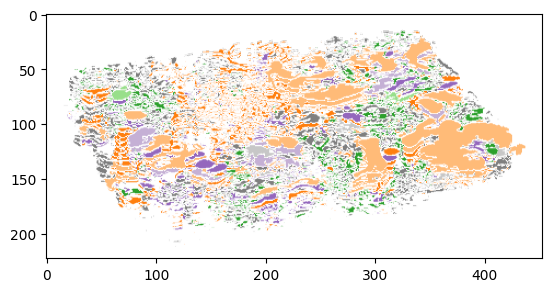

In [658]:
dtype_to_tiled = {
    'multiplex': multiplex_tiled,
    'xenium': xenium_tiled
}
dtype_to_masks = {
    'multiplex': multiplex_masks,
    'xenium': xenium_masks
}
dtype_to_thresholds = {
    'multiplex': {
        'myoepi_thresh': 40,
        'immune_thresh': 15,
        'area_thresh': 250,
    },
    'xenium': {
        'myoepi_thresh': 20,
        'immune_thresh': 12,
        'area_thresh': 250,
    },
}
dtype_to_channel_idxs = {
    'multiplex': {
        'epithelial': multiplex_channels.index('E-cadherin'),
        'immune': multiplex_channels.index('HLA-DR'),
        'myoepi': multiplex_channels.index('Keratin 5'),
    },
    'xenium': {
        'epithelial': xenium_channels.index('EPCAM'),
        'immune': xenium_channels.index('HLA-DQB2'),
        'myoepi': xenium_channels.index('KRT5'),
    }
}
cat_to_color = {
    'myTrue_imTrue_aTrue': sns.color_palette('tab20')[9],
    'myTrue_imTrue_aFalse': sns.color_palette('tab20')[8],
    'myTrue_imFalse_aTrue': sns.color_palette('tab20')[3],
    'myTrue_imFalse_aFalse': sns.color_palette('tab20')[2],
    'myFalse_imTrue_aTrue': sns.color_palette('tab20')[5],
    'myFalse_imTrue_aFalse': sns.color_palette('tab20')[4],
    'myFalse_imFalse_aTrue': sns.color_palette('tab20')[15],
    'myFalse_imFalse_aFalse': sns.color_palette('tab20')[14]
}

rgb, sid_to_data = to_stacked_rgb_category(
    case_to_config['HT704B1'], dtype_to_masks, dtype_to_tiled,
    dtype_to_channel_idxs, dtype_to_thresholds,
    boundary_dist=1, external_dist=4,
    spacing_scaler=10, squish_scaler=2,
    cat_to_color=cat_to_color
)
plt.imshow(rgb)

In [599]:
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

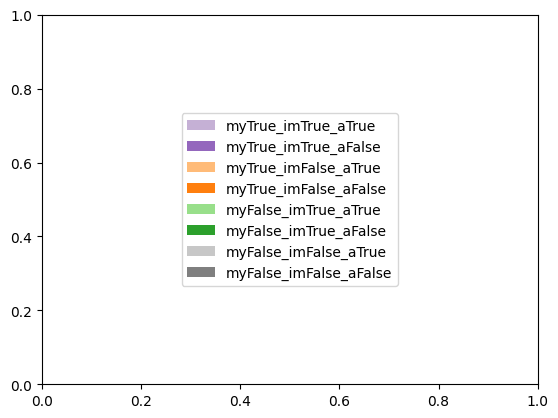

In [603]:
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=k) for k, c in cat_to_color.items()]
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')

In [593]:
# rgb, meta, labeled, cat_to_color = to_cmapped_rgb_category(
#     xenium_masks[0], xenium_tiled[0, 1], xenium_tiled[0, 2],
#     myoepi_thresh=20, immune_thresh=16, area_thresh=250,
#     boundary_dist=1, external_dist=4,
# )
# plt.imshow(rgb)

In [594]:
# rgb, meta, labeled, cat_to_color = to_cmapped_rgb_category(
#     multiplex_masks[0], multiplex_tiled[0, 1], multiplex_tiled[0, 2],
#     myoepi_thresh=50, immune_thresh=18, area_thresh=250,
#     boundary_dist=1, external_dist=4,
# )
# plt.imshow(rgb)

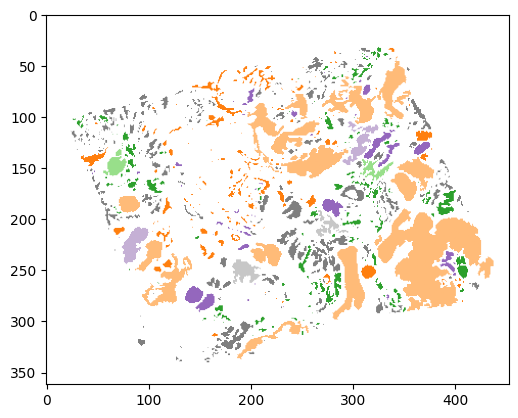

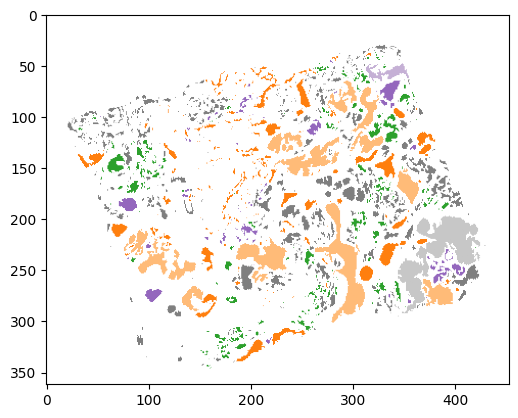

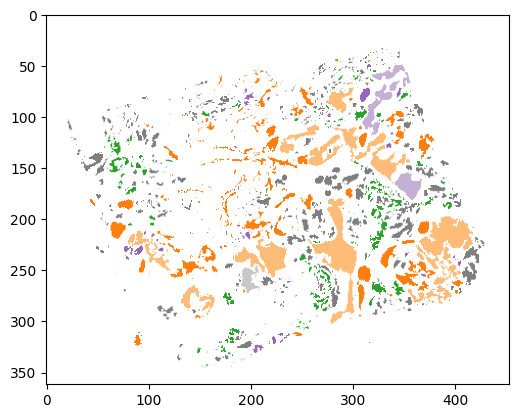

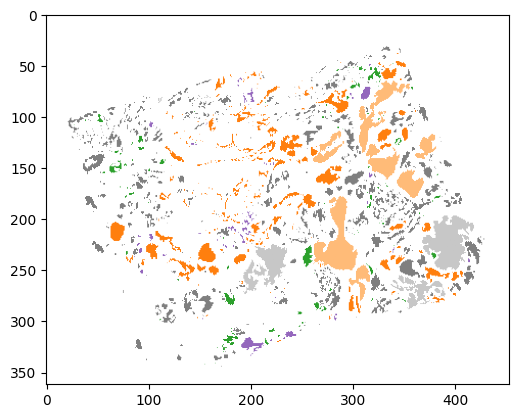

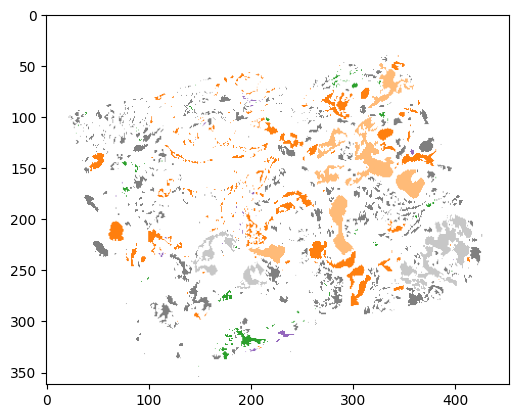

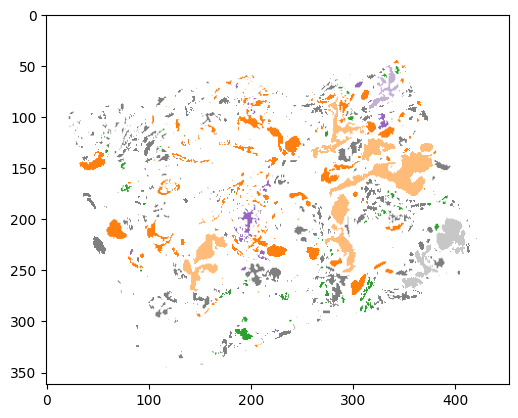

In [650]:
xenium_rgbs = []
for mask, tiled in zip(xenium_masks, xenium_tiled):
    rgb, meta, labeled, _ = to_cmapped_rgb_category(
        mask, tiled, dtype_to_channel_idxs['xenium']['myoepi'], dtype_to_channel_idxs['xenium']['immune'],
        myoepi_thresh=dtype_to_thresholds['xenium']['myoepi_thresh'],
        immune_thresh=dtype_to_thresholds['xenium']['immune_thresh'],
        area_thresh=dtype_to_thresholds['xenium']['area_thresh'],
        boundary_dist=1, external_dist=4, cat_to_color=cat_to_color
    )
    plt.imshow(rgb)
    plt.show()

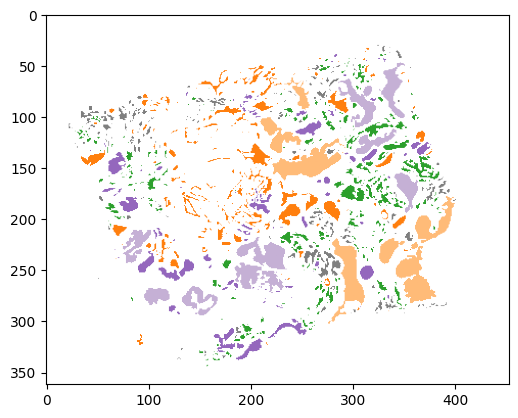

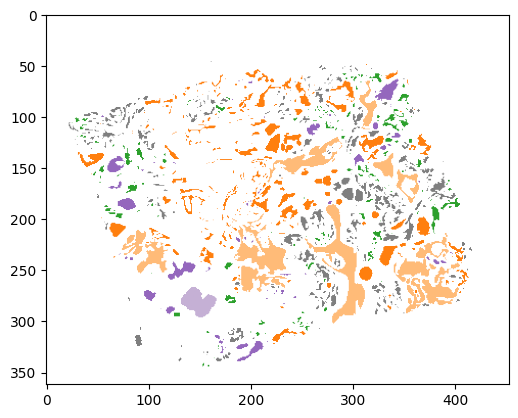

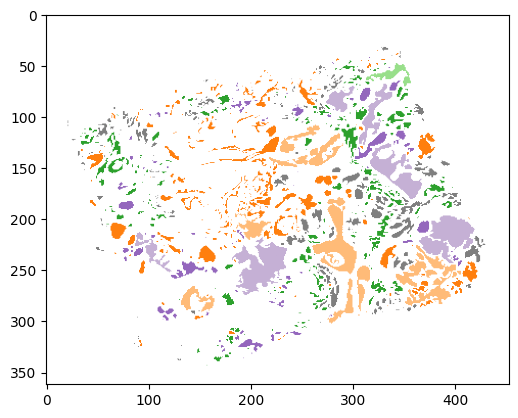

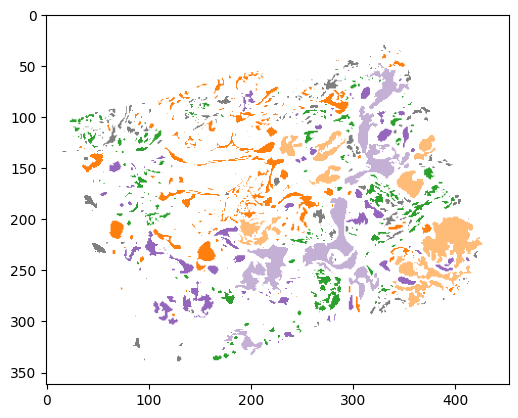

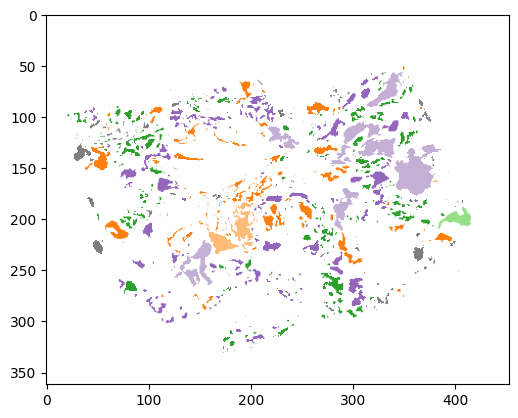

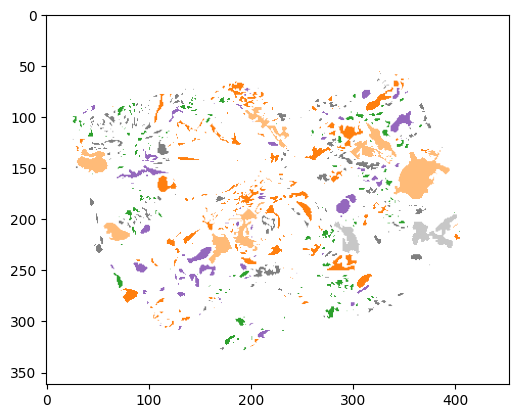

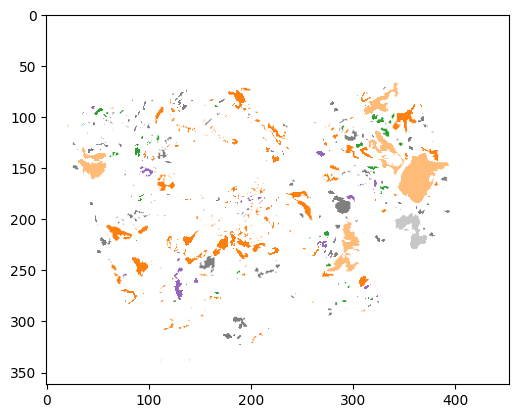

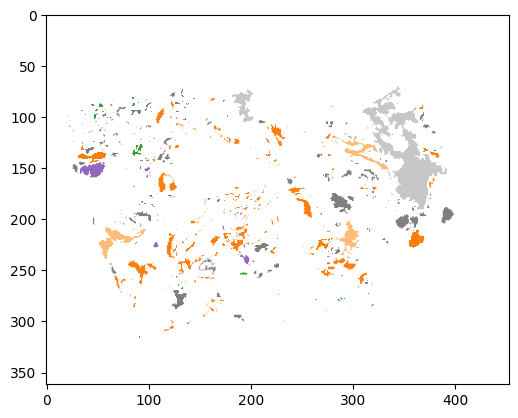

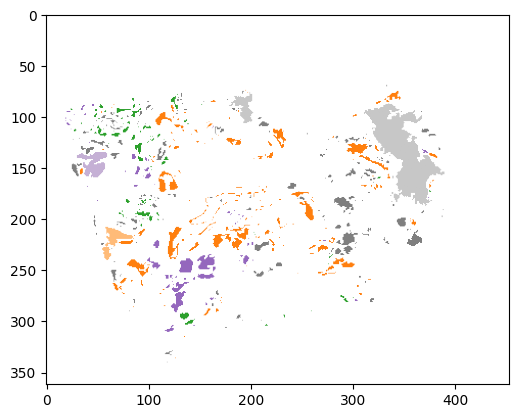

In [652]:
multiplex_rgbs = []
for mask, tiled in zip(multiplex_masks, multiplex_tiled):
    rgb, meta, labeled, _ = to_cmapped_rgb_category(
        mask, tiled, dtype_to_channel_idxs['multiplex']['myoepi'], dtype_to_channel_idxs['multiplex']['immune'],
        myoepi_thresh=dtype_to_thresholds['multiplex']['myoepi_thresh'],
        immune_thresh=dtype_to_thresholds['multiplex']['immune_thresh'],
        area_thresh=dtype_to_thresholds['multiplex']['area_thresh'],
        boundary_dist=1, external_dist=4, cat_to_color=cat_to_color
    )
    plt.imshow(rgb)
    plt.show()

In [609]:
# for x in meta.values():
#     if x['is_immune']:
#         r1, c1, r2, c2 = x['bbox_actual']
#         plt.imshow(pseudo[r1:r2, c1:c2])
#         plt.title(x['myoepi_mean'])
#         plt.show()

In [667]:
entry = next(iter(sid_to_data.values()))
entry.keys()

dict_keys(['dtype', 'rgb', 'position', 'meta', 'cat_to_color'])

In [668]:
meta = next(iter(entry['meta'].values()))
meta.keys()

dict_keys(['category', 'is_myoepi', 'is_immune', 'is_area', 'myoepi_mean', 'immune_mean', 'area', 'bbox_actual', 'prop', 'boundary_means', 'internal_means', 'external_means'])

In [671]:
dtype_to_channels = {
    'xenium': xenium_channels,
    'multiplex': multiplex_channels
}

def get_dtype_specific_dataframe(sid_to_data, dtype):
    keys = ['category', 'is_myoepi', 'is_immune', 'is_area', 'myoepi_mean', 'immune_mean', 'area']

    columns, idxs, data = [], [], []
    
    columns += ['dtype']
    columns += keys
    columns += ['r1', 'c1', 'r2', 'c2']
    columns += [f'boundary_{c}' for c in dtype_to_channels[dtype]]
    columns += [f'internal_{c}' for c in dtype_to_channels[dtype]]
    columns += [f'external_{c}' for c in dtype_to_channels[dtype]]
    for sid, entry in sid_to_data.items():
        if entry['dtype'] == dtype:
            for i, meta in entry['meta'].items():
                row = [dtype]
                row += [meta[key] for key in keys]
                row += meta['bbox_actual']
                row += meta['boundary_means'].tolist()
                row += meta['internal_means'].tolist()
                row += meta['external_means'].tolist()
                data.append(row)
                idxs.append(i)
    df = pd.DataFrame(data=data, columns=columns, index=idxs)
    return df
            
            
        
        
        

In [672]:
df = get_dtype_specific_dataframe(sid_to_data, 'xenium')
df

,dtype,category,is_myoepi,is_immune,is_area,myoepi_mean,immune_mean,area,r1,c1,...,external_CD8A,external_MS4A1,external_CD68,external_CD163,external_ACTA2,external_PDPN,external_HLA-DQB2,external_LAG3,external_PDCD1,external_GZMB
1,xenium,myFalse_imTrue_aFalse,False,True,False,9.520833,12.912698,29.0,28,320,...,2.484127,0.388889,7.746032,6.880952,24.841270,16.095238,12.912698,2.198413,1.214286,0.000000
2,xenium,myFalse_imFalse_aFalse,False,False,False,10.690476,7.221239,23.0,29,304,...,1.557522,0.000000,4.407080,5.477876,22.911504,16.389381,7.221239,0.132743,1.575221,0.000000
3,xenium,myTrue_imFalse_aFalse,True,False,False,27.133333,5.516854,16.0,29,331,...,0.213483,0.000000,0.786517,1.483146,8.707865,7.898876,5.516854,1.000000,0.000000,0.000000
4,xenium,myFalse_imFalse_aFalse,False,False,False,3.800000,10.075000,1.0,31,302,...,1.250000,0.425000,5.850000,6.800000,17.750000,14.750000,10.075000,0.000000,1.900000,0.000000
5,xenium,myTrue_imFalse_aFalse,True,False,False,35.357143,2.783333,5.0,32,278,...,0.783333,0.000000,3.683333,3.733333,12.783333,10.266667,2.783333,0.050000,3.800000,0.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,xenium,myFalse_imFalse_aFalse,False,False,False,0.000000,11.600000,5.0,327,161,...,3.783333,0.433333,6.616667,4.783333,17.433333,14.883333,11.600000,3.133333,1.183333,0.000000
746,xenium,myFalse_imTrue_aFalse,False,True,False,2.000000,12.604167,2.0,327,164,...,5.208333,0.583333,7.520833,1.645833,16.666667,19.041667,12.604167,3.875000,1.479167,0.000000
747,xenium,myFalse_imFalse_aFalse,False,False,False,0.307692,1.678571,14.0,329,125,...,1.476190,0.000000,2.107143,3.000000,4.880952,1.071429,1.678571,1.071429,0.000000,0.000000
748,xenium,myFalse_imTrue_aFalse,False,True,False,0.000000,61.732143,3.0,338,147,...,29.607143,13.196429,25.500000,35.696429,15.678571,25.571429,61.732143,18.714286,9.482143,10.696429


In [728]:
n_bins = 20
keep = [
    'myoepi_mean',
    'immune_mean',
    'area',
    'external_PTPRC',
    'external_HLA-DQB2',
    'external_CD68',
    'external_CD163',
    'external_CD8A',
    'external_ACTA2',
    'internal_PTPRC',
    'internal_HLA-DQB2',
    'internal_CD68',
    'internal_CD163',
    'internal_CD8A',
    'internal_ACTA2',
]
fdf = df[keep]

for c in fdf.columns:
    fdf[f'log_{c}'] = np.log1p(fdf[c])

fdf = fdf.sort_values('log_myoepi_mean')
bins = np.linspace(0, fdf['log_myoepi_mean'].max(), n_bins)

# smoosh last 4 for now
bins = bins[:-4]

fdf['bin'] = np.digitize(fdf['log_myoepi_mean'], bins)
bin_to_count = Counter(fdf['bin'])
grouped = fdf.groupby('bin').mean()
grouped['density'] = [bin_to_count[b] for b in grouped.index]
grouped['log_density'] = np.log1p(grouped['density'])


# artifially smoosh last bins for now

grouped

/tmp/ipykernel_922721/2958281932.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf[f'log_{c}'] = np.log1p(fdf[c])
/tmp/ipykernel_922721/2958281932.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf[f'log_{c}'] = np.log1p(fdf[c])
/tmp/ipykernel_922721/2958281932.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

,myoepi_mean,immune_mean,area,external_PTPRC,external_HLA-DQB2,external_CD68,external_CD163,external_CD8A,external_ACTA2,internal_PTPRC,...,log_external_CD8A,log_external_ACTA2,log_internal_PTPRC,log_internal_HLA-DQB2,log_internal_CD68,log_internal_CD163,log_internal_CD8A,log_internal_ACTA2,density,log_density
bin,,,,,,,,,,,,,,,,,,,,,
1,0.026581,10.125126,6.670304,10.678331,10.125126,6.773457,6.083884,2.200396,18.806908,8.890144,...,0.907612,2.891306,1.733003,2.407756,1.398996,1.014724,0.425968,2.551324,1283,7.157735
2,0.454165,10.037584,20.175743,10.463119,10.037584,6.678367,5.800858,2.066961,20.079066,7.666690,...,0.949674,2.970100,1.916065,2.713747,1.633566,1.339614,0.556103,2.579546,404,6.003887
3,0.862519,9.789503,12.258065,9.916334,9.789503,6.082082,5.526612,1.973676,19.377275,8.531589,...,0.890138,2.879125,1.963610,2.589154,1.564338,1.215032,0.536772,2.574573,310,5.739793
4,1.409104,9.029363,10.526570,8.506345,9.029363,5.486912,4.876830,1.463576,18.256109,7.477202,...,0.686133,2.789023,1.572116,2.336483,1.352504,1.120475,0.428419,2.545164,207,5.337538
5,2.066189,8.874515,10.007812,8.392307,8.874515,5.449715,4.529999,1.523590,18.336899,7.582995,...,0.720865,2.800992,1.802535,2.362542,1.394940,0.937081,0.382913,2.574238,128,4.859812
6,2.968419,7.867493,11.144144,7.537575,7.867493,4.862909,3.809592,1.149370,17.403288,8.558427,...,0.607924,2.753178,1.773188,2.175964,1.526526,0.977509,0.339268,2.510804,111,4.718499
7,4.074655,7.890511,15.157303,7.493638,7.890511,4.901420,4.144291,1.266675,16.327533,7.147724,...,0.675148,2.656684,1.793159,2.493121,1.490354,1.169769,0.497921,2.566007,89,4.499810
8,5.500681,7.442899,13.627451,7.484724,7.442899,4.427455,3.722769,1.392932,18.453684,7.828794,...,0.677772,2.841077,1.725881,2.050457,1.252647,0.948941,0.450882,2.796155,102,4.634729
9,7.454022,7.715680,23.881944,7.642423,7.715680,5.246531,4.326750,1.139565,16.817331,6.350064,...,0.608074,2.667851,1.628563,2.182154,1.321479,0.929103,0.299677,2.814587,144,4.976734


<Axes: xlabel='log_myoepi_mean', ylabel='Count'>

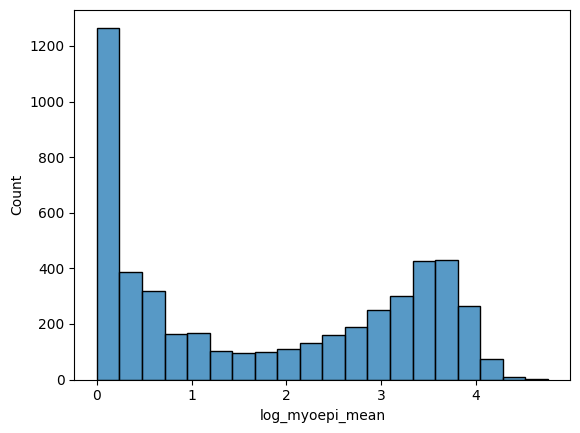

In [729]:
sns.histplot(fdf['log_myoepi_mean'], bins=n_bins)
# sns.kdeplot(fdf['log_myoepi_mean'])
# sns.barplot(grouped, x='bin', y='density', h)

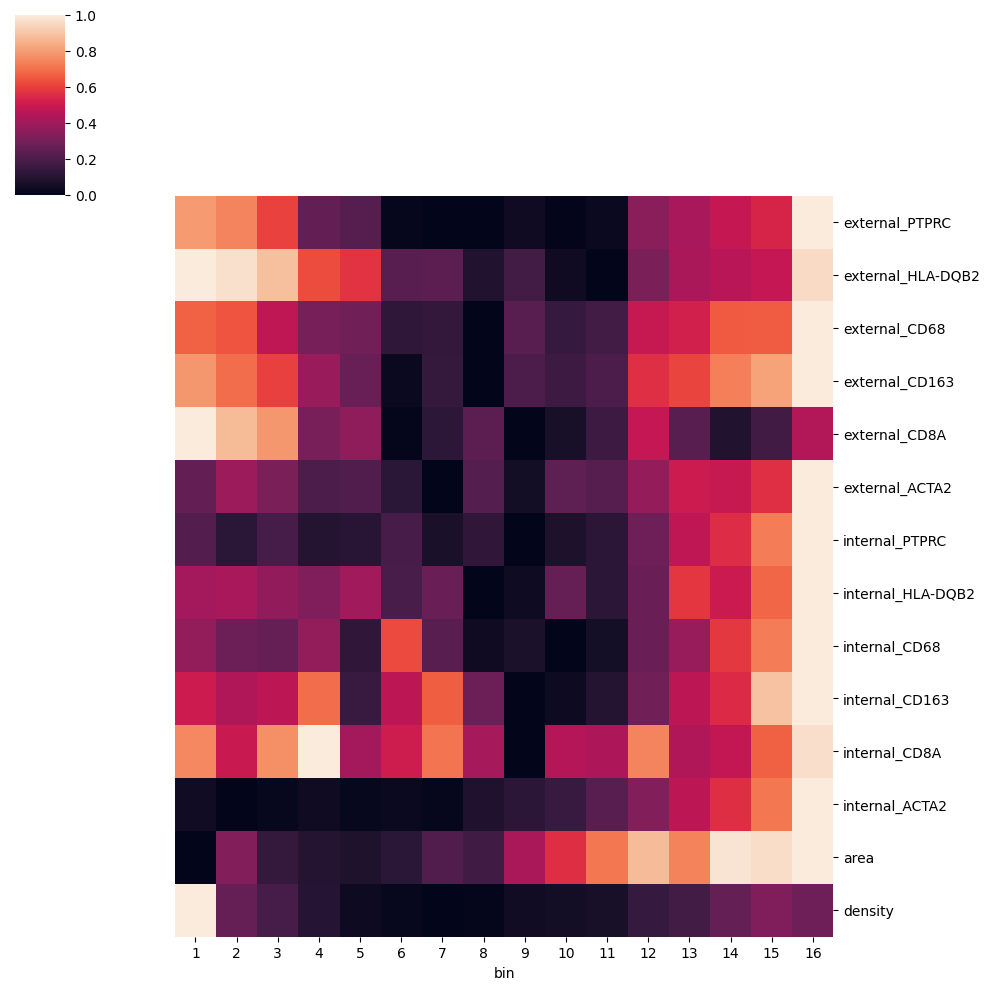

In [733]:
order = [
    'external_PTPRC',
    'external_HLA-DQB2',
    'external_CD68',
    'external_CD163',
    'external_CD8A',
    'external_ACTA2',
    'internal_PTPRC',
    'internal_HLA-DQB2',
    'internal_CD68',
    'internal_CD163',
    'internal_CD8A',
    'internal_ACTA2',
    'area',
    'density'
]
sns.clustermap(grouped.T.loc[order], standard_scale=0, row_cluster=False, col_cluster=False)

<Axes: >

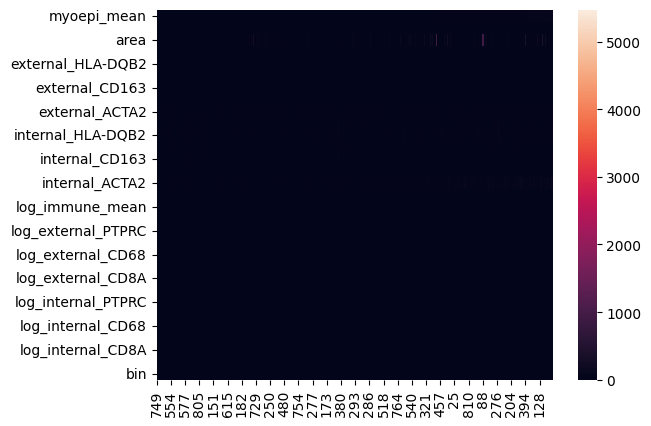

In [731]:
sns.heatmap(fdf.T, )

<Axes: >

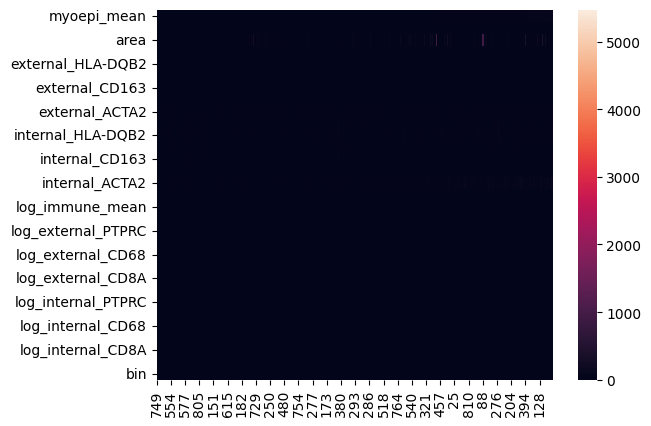

In [732]:
sns.heatmap(fdf.T)

In [680]:
x = fdf['myoepi_mean'].values
x = np.sort(x)

In [681]:
x

array([  0.        ,   0.        ,   0.        , ...,  89.4       ,
       105.72727273, 115.875     ])

In [683]:
np.digitize(x, bins=np.)

ValueError: object of too small depth for desired array

In [685]:
bins = np.linspace(0, fdf['myoepi_mean'].max(), 100)
np.digitize(x, bins)

array([  1,   1,   1, ...,  77,  91, 100])

(362, 453) (362, 453, 2)


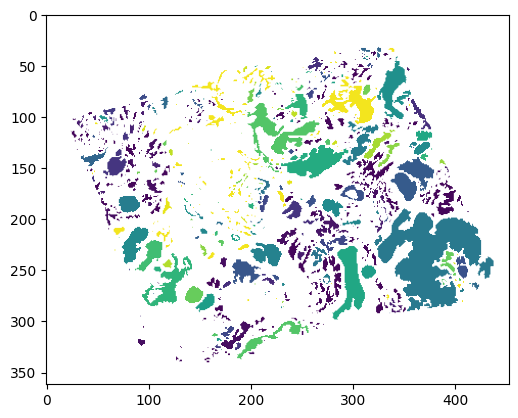

In [427]:
rgb, props = to_cmapped_rgb(masks[0], xenium_tiled[0], 1, vmax=50)
plt.imshow(rgb)

In [428]:
def to_stacked_rgb(config, dtype_to_masks, dtype_to_tiled, value_idx,
                   dtype_to_vmax=50., spacing_scaler=10, squish_scaler=2):
    target_size = next(iter(dtype_to_masks.values()))[0].shape[:2]
    dtypes = dtype_to_masks.keys()
    
    positions, sids, dts = zip(*[(entry['position'], entry['sid'], entry['data'][0]['dtype'])
                                    for entry in config['sections']
                                    if entry['data'][0]['dtype'] in dtypes])
    
    sid_to_data = {}
    for dtype in dtypes:
        intensities = dtype_to_tiled[dtype]
        masks = dtype_to_masks[dtype]
        vmax = dtype_to_vmax if not isinstance(dtype_to_vmax, dict) else dtype_to_vmax[dtype]
        ps, ids = zip(*[(p, sid) for sid, p, dt in zip(sids, positions, dts) if dt == dtype])
        for sid, mask, intensity, position in zip(ids, masks, intensities, ps):
            rgb, props = to_cmapped_rgb(mask, intensity, value_idx, vmax=vmax)
            sid_to_data[sid] = {
                'rgb': rgb,
                'position': position,
                'props': props
            }

    blank = np.zeros((target_size[-2] // squish_scaler, target_size[-1], 4))

    blank = np.concatenate(
        (blank, np.zeros((max(positions) // spacing_scaler, blank.shape[1], blank.shape[2])))
    )

    for sid in sids:
        data = sid_to_data[sid]
        rgb = data['rgb']
        position = data['position'] // spacing_scaler
        size = (rgb.shape[0] // squish_scaler, rgb.shape[1])
        rgb = utils.rescale(rgb, size=size, dim_order='h w c')

        # pad to size of blank with a translation
        top = np.zeros((position, blank.shape[1], blank.shape[2]))
        bottom = np.zeros((blank.shape[0] - (position + rgb.shape[0]), blank.shape[1], blank.shape[2]))
        padded = np.concatenate((top, rgb, bottom))

        m = blank[..., -1] == 0
        blank[m] = padded[m]

    return blank, sid_to_data

(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)
(362, 453) (362, 453, 2)


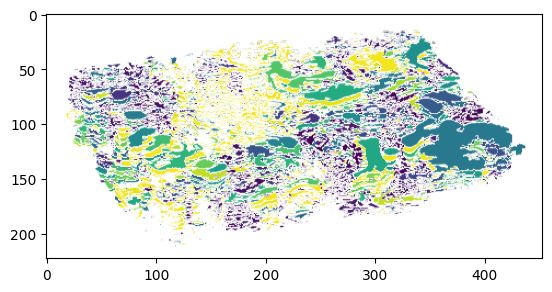

In [429]:
dtype_to_masks = {
    'xenium': xenium_masks,
    'multiplex': multiplex_masks
}
dtype_to_tiled = {
    'xenium': xenium_tiled,
    'multiplex': multiplex_tiled
}
img, sid_to_data = to_stacked_rgb(case_to_config['HT704B1'], dtype_to_masks, dtype_to_tiled, 1)
plt.imshow(img)

In [430]:
props = next(iter(sid_to_data.values()))['props']

In [441]:
means[:10]

[array([47.4137931 , 16.68965517]),
 array([45.39130435, 16.47826087]),
 array([70.625, 67.   ]),
 array([23.,  1.]),
 array([52.8, 78.6]),
 array([41.38461538,  0.53846154]),
 array([42.5,  0. ]),
 array([21., 10.]),
 array([45.9,  0.7]),
 array([28., 13.])]

10510 10510


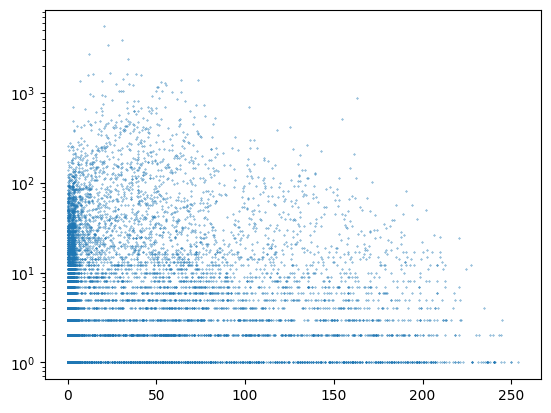

In [445]:
means, areas = [], []
for sid, data in sid_to_data.items():
    for p in data['props']:
        means.append(p.intensity_mean[1])
        areas.append(p.area)
print(len(means), len(areas))
plt.scatter(means, areas, s=.1)
ax = plt.gca()
plt.yscale('log')

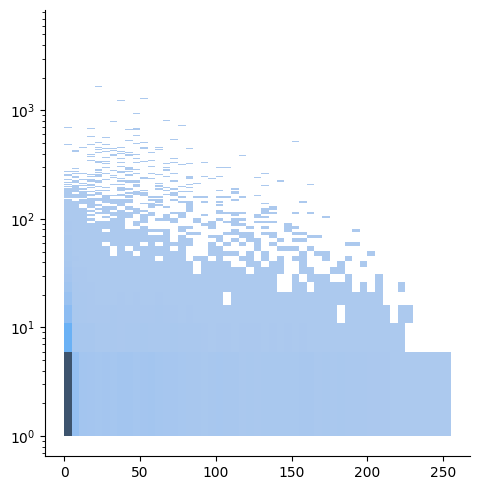

In [449]:
sns.displot(x=means, y=areas, binwidth=(5,5), )
plt.yscale('log')